In [1]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import re

np.random.seed(42)
tf.random.set_seed(42)

# COLLECT AND PREPARE DATA

In [2]:
base_path = "/Users/jin/Documents/S3/Machine_Learning_for_Internet_of_Things/final_project/data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [3]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [4]:
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [5]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [6]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-12-14 18:05:39.149832: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-14 18:05:39.150600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [9]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [10]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def get_sorted_names(directory_path):
    # Change to the specified directory
    os.chdir(directory_path)

    # Get a list of all files in the directory
    files = [file for file in os.listdir() if file.lower().endswith('.png')]

    # Sort the files based on the numeric part of the names
    files.sort(key=natural_sort_key)

    # Collect the sorted names in a list
    sorted_names = [f"/Users/jin/Documents/S3/Machine_Learning_for_Internet_of_Things/final_project/test/cropped_words/cropped_word_{index}.png" for index, file in enumerate(files, start=1)]

    return sorted_names

# Replace 'your_directory_path' with the actual path where your images are located
arduino_train_paths = get_sorted_names('/Users/jin/Documents/S3/Machine_Learning_for_Internet_of_Things/final_project/test/cropped_words')

# Print the sorted names
print(arduino_train_paths)

['/Users/jin/Documents/S3/Machine_Learning_for_Internet_of_Things/final_project/test/cropped_words/cropped_word_1.png', '/Users/jin/Documents/S3/Machine_Learning_for_Internet_of_Things/final_project/test/cropped_words/cropped_word_2.png', '/Users/jin/Documents/S3/Machine_Learning_for_Internet_of_Things/final_project/test/cropped_words/cropped_word_3.png', '/Users/jin/Documents/S3/Machine_Learning_for_Internet_of_Things/final_project/test/cropped_words/cropped_word_4.png', '/Users/jin/Documents/S3/Machine_Learning_for_Internet_of_Things/final_project/test/cropped_words/cropped_word_5.png', '/Users/jin/Documents/S3/Machine_Learning_for_Internet_of_Things/final_project/test/cropped_words/cropped_word_6.png', '/Users/jin/Documents/S3/Machine_Learning_for_Internet_of_Things/final_project/test/cropped_words/cropped_word_7.png', '/Users/jin/Documents/S3/Machine_Learning_for_Internet_of_Things/final_project/test/cropped_words/cropped_word_8.png', '/Users/jin/Documents/S3/Machine_Learning_for_I

In [11]:
# Open the file in read mode
with open('/Users/jin/Documents/S3/Machine_Learning_for_Internet_of_Things/final_project/arduino_words.txt', 'r') as file:
    # Read the content and split it into a list of words
    words = file.read().split()

arduino_train_labels = [word.strip('.,!?;()[]{}"\'') for word in words if word.isalpha()]
arduino_train_labels.pop(340)
arduino_train_labels.pop(340)
# Print the words in the desired format
print(len(arduino_train_labels))

arduino_train_ds = prepare_dataset(arduino_train_paths, arduino_train_labels)

491


In [24]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

2023-12-14 18:06:05.069822: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-12-14 18:06:05.421954: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


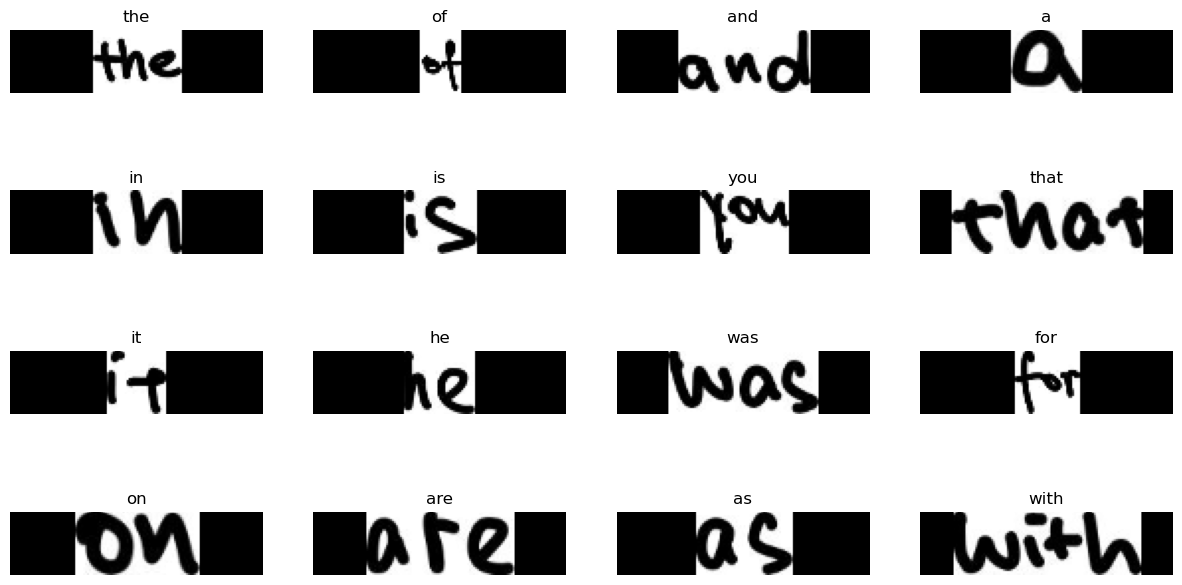

In [12]:
for data in arduino_train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

In [13]:
classes = ["the","of","and","a","to","in","is","you","that","it","he","was","for","on","are","as","with","his","they","I","at","be","this","have","from","or","one","had","by","word","but","not","what","all","were","we","when","your","can","said","there","use","an","each","which","she","do","how","their","if","will","up","other","about","out","many","then","them","these","so","some","her","would","make","like","him","into","time","has","look","two","more","write","go","see","number","no","way","could","people","my","than","first","water","been","call","who","oil","its","now","find","long","down","day","did","get","come","made","may","part"]
classes = classes[:20]
class2index = {word:ix for ix,word in enumerate(classes)}
index2class = {ix:word for ix,word in enumerate(classes)}

In [25]:
images_words = []
labels_words = []

for data in train_ds:
    images, labels = data["image"], data["label"]
    for i in range(len(images)):
        
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]
    
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")
        
        if label in class2index:
            images_words.append(img)
            labels_words.append(class2index[label])
    

In [14]:
arduino_images_words = []
arduino_labels_words = []

for data in arduino_train_ds:
    images, labels = data["image"], data["label"]
    for i in range(len(images)):
        
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]
    
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")
        
        if label in class2index:
            arduino_images_words.append(img)
            arduino_labels_words.append(class2index[label])
    

In [43]:
print(len(arduino_images_words), len(arduino_labels_words))

arduino_new_train_image = arduino_images_words[:400]
arduino_new_train_label = arduino_labels_words[:400]

arduino_new_val_image = arduino_images_words[400:450]
arduino_new_val_label = arduino_labels_words[400:450]

arduino_new_test_image = arduino_images_words[450:491]
arduino_new_test_label = arduino_labels_words[450:491]


491 491


In [27]:
new_val_num = int(np.floor(0.20*len(images_words)))
new_val = images_words[:new_val_num]
new_val_label = labels_words[:new_val_num]

new_train = images_words[new_val_num:]
new_train_label = labels_words[new_val_num:]


# MODEL


In [53]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(30, (3, 3),activation='relu', input_shape=(32,128,1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(30, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(30, (3, 3),activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(121, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(20))
model.add(tf.keras.layers.Softmax())
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 126, 30)       300       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 63, 30)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 61, 30)        8130      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 30, 30)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 28, 30)         8130      
                                                                 
 flatten_2 (Flatten)         (None, 3360)             

In [54]:
new_train = np.asarray(new_train)
new_train_label = np.asarray(new_train_label)
new_val = np.asarray(new_val)
new_val_label = np.asarray(new_val_label)
history = model.fit(new_train, new_train_label, epochs=10, 
                    validation_data=(new_val, new_val_label))

Epoch 1/10


/Users/jin/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-12-14 19:08:23.753009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


543/544 [============================>.] - ETA: 0s - loss: 1.5756 - accuracy: 0.5770

2023-12-14 19:08:33.923432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


544/544 [==============================] - 12s 20ms/step - loss: 1.5741 - accuracy: 0.5775 - val_loss: 0.8621 - val_accuracy: 0.7341
Epoch 2/10
544/544 [==============================] - 11s 20ms/step - loss: 0.5714 - accuracy: 0.8269 - val_loss: 0.5136 - val_accuracy: 0.8485
Epoch 3/10
544/544 [==============================] - 11s 20ms/step - loss: 0.3559 - accuracy: 0.8913 - val_loss: 0.5349 - val_accuracy: 0.8499
Epoch 4/10
544/544 [==============================] - 11s 20ms/step - loss: 0.2402 - accuracy: 0.9249 - val_loss: 0.3752 - val_accuracy: 0.8959
Epoch 5/10
544/544 [==============================] - 11s 20ms/step - loss: 0.1741 - accuracy: 0.9429 - val_loss: 0.3972 - val_accuracy: 0.8922
Epoch 6/10
544/544 [==============================] - 11s 20ms/step - loss: 0.1422 - accuracy: 0.9548 - val_loss: 0.4391 - val_accuracy: 0.8823
Epoch 7/10
544/544 [==============================] - 11s 20ms/step - loss: 0.1205 - accuracy: 0.9607 - val_loss: 0.4939 - val_accuracy: 0.8915
Epo

In [81]:
model.save('/Users/jin/Documents/S3/Machine_Learning_for_Internet_of_Things/final_project/model_20class.h5')

In [39]:
from tensorflow.keras.models import Model

intermediate_layer_index = 7
intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[intermediate_layer_index].output)

preds_arduino_train = intermediate_layer_model.predict(np.asarray(arduino_new_train_image))
preds_arduino_val = intermediate_layer_model.predict(np.asarray(arduino_new_val_image))
preds_arduino_test = intermediate_layer_model.predict(np.asarray(arduino_new_test_image))

In [36]:
preds_arduino_train.shape

(400, 64)

In [75]:
print(arduino_new_train_label.tolist())

preds_arduino_train = str(preds_arduino_train.tolist())
preds_arduino_train = preds_arduino_train.replace(']','}')
preds_arduino_train = preds_arduino_train.replace('[','{')
preds_arduino_train = preds_arduino_train.replace('},','},\n')
f = open("/Users/jin/Documents/S3/Machine_Learning_for_Internet_of_Things/final_project/transfer_data/new_train_outputs.txt", "w")
f.write(preds_arduino_train)


print(arduino_new_val_label.tolist())

preds_arduino_val = str(preds_arduino_val.tolist())
preds_arduino_val = preds_arduino_val.replace(']','}')
preds_arduino_val = preds_arduino_val.replace('[','{')
preds_arduino_val = preds_arduino_val.replace('},','},\n')
f = open("/Users/jin/Documents/S3/Machine_Learning_for_Internet_of_Things/final_project/transfer_data/new_val_outputs.txt", "w")
f.write(preds_arduino_val)


print(arduino_new_test_label.tolist())

preds_arduino_test = str(preds_arduino_test.tolist())
preds_arduino_test = preds_arduino_test.replace(']','}')
preds_arduino_test = preds_arduino_test.replace('[','{')
preds_arduino_test = preds_arduino_test.replace('},','},\n')
f = open("/Users/jin/Documents/S3/Machine_Learning_for_Internet_of_Things/final_project/transfer_data/new_test_outputs.txt", "w")
f.write(preds_arduino_test)

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1

In [82]:
print(arduino_new_test_label.tolist())

[18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
